## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

- Nelson Aldana
- Diego Ojeda
- Daniel Rojas


**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [2]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [3]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

In [4]:
np.shape(x_train)

(25000,)

In [5]:
np.shape(y_train)

(25000,)

In [6]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la primera observación de entrenamiento:

In [7]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [8]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

Veamos el primer comentario de entrenamiento que es positivo:

In [9]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [10]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [11]:
max_features

20000

In [12]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Epoch 1/3
391/391 [==============================] - 117s 300ms/step - loss: 0.4591 - accuracy: 0.7782 - val_loss: 0.3629 - val_accuracy: 0.8470
Epoch 2/3
391/391 [==============================] - 114s 293ms/step - loss: 0.2356 - accuracy: 0.9126 - val_loss: 0.3891 - val_accuracy: 0.8454
Epoch 3/3
391/391 [==============================] - 116s 297ms/step - loss: 0.1356 - accuracy: 0.9530 - val_loss: 0.4471 - val_accuracy: 0.8428
Desempeño (exactitud): accu_v1=0.8428000211715698 , accu_v2=0.8349999785423279
Epoch 1/3
391/391 [==============================] - 111s 284ms/step - loss: 0.2330 - accuracy: 0.9149 - val_loss: 0.2192 - val_accuracy: 0.9193
Epoch 2/3
391/391 [==============================] - 114s 291ms/step - loss: 0.1140 - accuracy: 0.9629 - val_loss: 0.2909 - val_accuracy: 0.9027
Epoch 3/3
391/391 [==============================] - 113s 289ms/step - loss: 0.0950 - accuracy: 0.9696 - val_loss: 0.3469 - val_accuracy: 0.8964
Desempeño (exactitud): accu_v1=0.896399974822998 , 

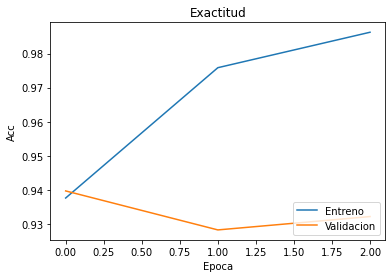

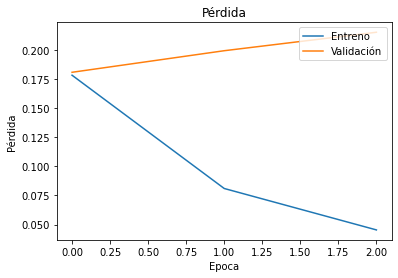

In [14]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [15]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [16]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11221  1279]
 [  912 11588]]
Exactitud:  0.9123600125312805


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [17]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10163  2337]
 [ 1788 10712]]
Exactitud:  0.8349999785423279


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

### 1.1.1 Red Uni-Direccional - LSTM

In [18]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_LSTM_uni = keras.Model(inputs, outputs)
model_LSTM_uni.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_LSTM_uni = keras.Model(inputs, outputs)
    model_LSTM_uni.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_LSTM_uni.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_LSTM_uni.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_LSTM_uni.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_LSTM_uni.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('U_LSTM_part='+str(r)+'.h5')
        model_LSTM_uni.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Epoch 1/3
391/391 [==============================] - 94s 241ms/step - loss: 0.4794 - accuracy: 0.7699 - val_loss: 0.3772 - val_accuracy: 0.8418
Epoch 2/3
391/391 [==============================] - 90s 231ms/step - loss: 0.2380 - accuracy: 0.9122 - val_loss: 0.3625 - val_accuracy: 0.8502
Epoch 3/3
391/391 [==============================] - 94s 241ms/step - loss: 0.1329 - accuracy: 0.9567 - val_loss: 0.4618 - val_accuracy: 0.8489
Desempeño (exactitud): accu_v1=0.8488799929618835 , accu_v2=0.8333200216293335
Epoch 1/3
391/391 [==============================] - 96s 245ms/step - loss: 0.2455 - accuracy: 0.9099 - val_loss: 0.2301 - val_accuracy: 0.9137
Epoch 2/3
391/391 [==============================] - 92s 237ms/step - loss: 0.1204 - accuracy: 0.9600 - val_loss: 0.2940 - val_accuracy: 0.9056
Epoch 3/3
391/391 [==============================] - 93s 238ms/step - loss: 0.1250 - accuracy: 0.9552 - val_loss: 0.4136 - val_accuracy: 0.8924
Desempeño (exactitud): accu_v1=0.8924000263214111 , accu_

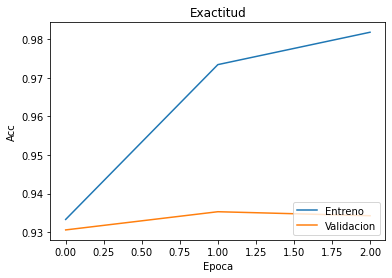

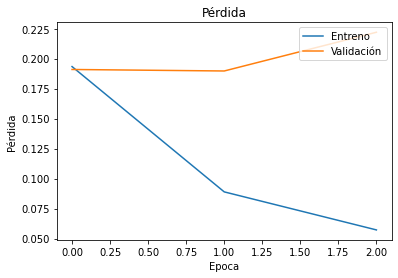

In [20]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [21]:
Y_predt = model_LSTM_uni.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_LSTM_uni.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12058   442]
 [  450 12050]]
Exactitud:  0.9643200039863586


In [22]:
Y_predv = model_LSTM_uni.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_LSTM_uni.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10628  1872]
 [ 1989 10511]]
Exactitud:  0.8455600142478943


**Podemos observar que un modelo Unidireccional con celdas LSTM en este caso tiene un mejor desempeño que un modelo usando celdas Bidireccionales tipo LSTM, con exactidudes de 85% contra 83% respectivamente.**

### 1.1.2 Red Uni-Direccional - Red Simple

In [23]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.SimpleRNN(64, return_sequences=True)(x)
x = layers.SimpleRNN(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_NN_uni = keras.Model(inputs, outputs)
model_NN_uni.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          12352     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,580,673
Trainable params: 2,580,673
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_NN_uni = keras.Model(inputs, outputs)
    model_NN_uni.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_NN_uni.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_NN_uni.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_NN_uni.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_NN_uni.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('U_NN_part='+str(r)+'.h5')
        model_NN_uni.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Epoch 1/3
391/391 [==============================] - 43s 109ms/step - loss: 0.6795 - accuracy: 0.5637 - val_loss: 0.5965 - val_accuracy: 0.6789
Epoch 2/3
391/391 [==============================] - 42s 107ms/step - loss: 0.4166 - accuracy: 0.8072 - val_loss: 0.6057 - val_accuracy: 0.7271
Epoch 3/3
391/391 [==============================] - 41s 106ms/step - loss: 0.1340 - accuracy: 0.9487 - val_loss: 0.6723 - val_accuracy: 0.7918
Desempeño (exactitud): accu_v1=0.7918400168418884 , accu_v2=0.787880003452301
Epoch 1/3
391/391 [==============================] - 41s 106ms/step - loss: 0.4091 - accuracy: 0.8215 - val_loss: 0.4590 - val_accuracy: 0.7868
Epoch 2/3
391/391 [==============================] - 41s 105ms/step - loss: 0.1711 - accuracy: 0.9370 - val_loss: 0.3914 - val_accuracy: 0.8420
Epoch 3/3
391/391 [==============================] - 42s 107ms/step - loss: 0.0310 - accuracy: 0.9911 - val_loss: 0.4897 - val_accuracy: 0.8507
Desempeño (exactitud): accu_v1=0.8507199883460999 , accu_v

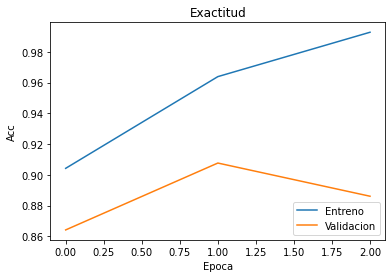

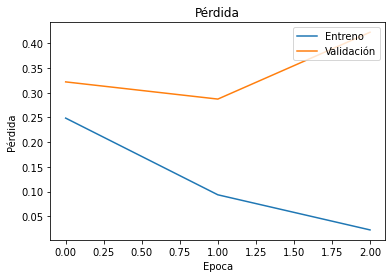

In [25]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [26]:
Y_predt = model_NN_uni.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_NN_uni.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11667   833]
 [  617 11883]]
Exactitud:  0.9419999718666077


In [27]:
Y_predv = model_NN_uni.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_NN_uni.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[8550 3950]
 [3449 9051]]
Exactitud:  0.704039990901947


**Podemos observar que para un modelo de redes densamente conectadas en este caso tiene no tiene mejor desempeño que un modelo usando celdas Unidireccionales LSTM, con exactidudes de 70% contra 85% respectivamente.**

### 1.1.3 Unidireccional GRU

En este caso ussaremos una red neuronal unidireccional GRU (Unidad recurrente cerrada). Esta se diferencia de LSTM porque no tiene que usar una unidad de memoria para controlar el flujo de información. Puede hacer uso directamente de las capas escondidas sin ningún control, tiene menos parámetros, por lo tanto entrena un poco más rápido, sin embargo con datos muy grandes LSTM podría ser mejor en algunos casos. 
A continuación definiremos  las capas (2) en este caso unidireccionales. 

In [37]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades GRU unidireccionales
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_GRU_uni = keras.Model(inputs, outputs)
model_GRU_uni.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,622,273
Trainable params: 2,622,273
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_GRU_uni = keras.Model(inputs, outputs)
    model_GRU_uni.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_GRU_uni.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_GRU_uni.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_GRU_uni.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_GRU_uni.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('U_GRU_part='+str(r)+'.h5')
        model_GRU_uni.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Epoch 1/3
391/391 [==============================] - 82s 209ms/step - loss: 0.4897 - accuracy: 0.7523 - val_loss: 0.3462 - val_accuracy: 0.8534
Epoch 2/3
391/391 [==============================] - 82s 210ms/step - loss: 0.2998 - accuracy: 0.8755 - val_loss: 0.3783 - val_accuracy: 0.8455
Epoch 3/3
391/391 [==============================] - 85s 217ms/step - loss: 0.1551 - accuracy: 0.9417 - val_loss: 0.4251 - val_accuracy: 0.8452
Desempeño (exactitud): accu_v1=0.8452000021934509 , accu_v2=0.8343600034713745
Epoch 1/3
391/391 [==============================] - 83s 212ms/step - loss: 0.2115 - accuracy: 0.9207 - val_loss: 0.2073 - val_accuracy: 0.9210
Epoch 2/3
391/391 [==============================] - 83s 212ms/step - loss: 0.0778 - accuracy: 0.9768 - val_loss: 0.3106 - val_accuracy: 0.9005
Epoch 3/3
391/391 [==============================] - 82s 210ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.4953 - val_accuracy: 0.8802
Desempeño (exactitud): accu_v1=0.8801599740982056 , accu_

**Se puede observar que los resultados de accuracy en los datos de prueba estan en 84%, mucho mejor que en el LSTM unidireccional realizado en el punto anterior que fue alrededor de 80%.**

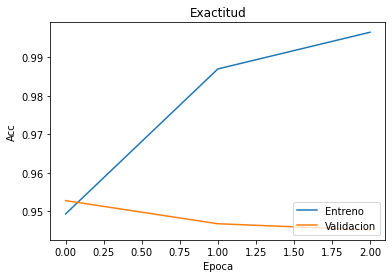

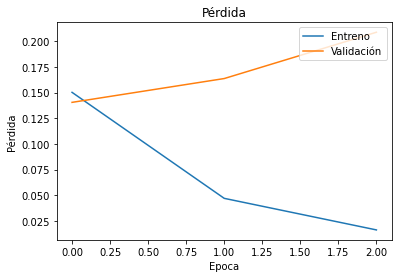

In [39]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [41]:
Y_predt = model_GRU_uni.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_GRU_uni.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12106   394]
 [  299 12201]]
Exactitud:  0.9722800254821777


Al evaluar la exactitud sobre el set de trainning, se tiene una métrica de 96%, comparada con un 91% con red simple Unidireccional.

In [40]:
Y_predv = model_GRU_uni.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_GRU_uni.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10743  1757]
 [ 1767 10733]]
Exactitud:  0.8590400218963623


**Evaluando el modelo para predecir sobre los datos de validación a continuación se observa una exactitud de 86%, mejor que LSTM unidireccional (84%), que la red simple (70%), y también mejor que la LSTM Bidireccional del inicio de este notebook que presentó una exactitud de 81%**

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

## 1.2.1 Red Bidireccional LSTM

Incrementaremos el numero de epocas.

In [28]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_BLST_Opt = keras.Model(inputs, outputs)
model_BLST_Opt.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=10

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_BLST_Opt = keras.Model(inputs, outputs)
    model_BLST_Opt.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_BLST_Opt.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_BLST_Opt.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_BLST_Opt.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_BLST_Opt.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BLSTM_Opt_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Epoch 1/10
391/391 [==============================] - 115s 293ms/step - loss: 0.4622 - accuracy: 0.7740 - val_loss: 0.3689 - val_accuracy: 0.8502
Epoch 2/10
391/391 [==============================] - 113s 289ms/step - loss: 0.2342 - accuracy: 0.9114 - val_loss: 0.3812 - val_accuracy: 0.8362
Epoch 3/10
391/391 [==============================] - 113s 290ms/step - loss: 0.1197 - accuracy: 0.9585 - val_loss: 0.5110 - val_accuracy: 0.8192
Epoch 4/10
391/391 [==============================] - 114s 292ms/step - loss: 0.0757 - accuracy: 0.9750 - val_loss: 0.5749 - val_accuracy: 0.8009
Epoch 5/10
391/391 [==============================] - 113s 289ms/step - loss: 0.0725 - accuracy: 0.9770 - val_loss: 0.5574 - val_accuracy: 0.8390
Epoch 6/10
391/391 [==============================] - 113s 288ms/step - loss: 0.0483 - accuracy: 0.9847 - val_loss: 0.6334 - val_accuracy: 0.8368
Epoch 7/10
391/391 [==============================] - 113s 288ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 0.8620 -

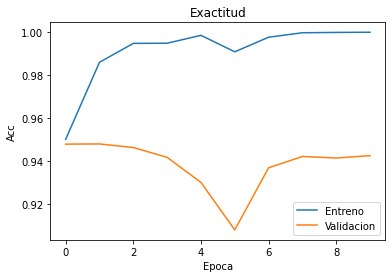

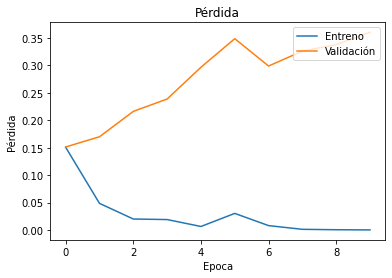

In [30]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [32]:
Y_predt = model_BLST_Opt.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_BLST_Opt.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12163   337]
 [  382 12118]]
Exactitud:  0.9712399840354919


In [33]:
Y_predv = model_BLST_Opt.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_BLST_Opt.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10749  1751]
 [ 2008 10492]]
Exactitud:  0.8496400117874146


**Podemos ver que incrementando el numero de epocas para un modelo bidireccional LSTM la exactidud se incrementa de 83% a 85%, sin embargo, sigue teniendo mejores valores de exactitud la red GRU unidireccional que arroja un 86%**

## 1.2.2 Red Unidireccional LSTM

Incrementaremos el numero de epocas.

In [35]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_ULSTM_Opt = keras.Model(inputs, outputs)
model_ULSTM_Opt.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
391/391 [==============================] - 88s 225ms/step - loss: 0.4382 - accuracy: 0.7953 - val_loss: 0.3820 - val_accuracy: 0.8286
Epoch 2/10
391/391 [==============================] - 91s 234ms/step - loss: 0.2300 - accuracy: 0.9120 - val_loss: 0.3720 - val_accuracy: 0.8465
Epoch 3/10
391/391 [==============================] - 92s 235ms/step - loss: 0.1587 - accuracy: 0.9432 - val_loss: 0.4443 - val_accuracy: 0.8543
Epoch 4/10
391/391 [==============================] - 92s 235ms/step - loss: 0.1406 - accuracy: 0.9502 - val_loss: 0.5177 - val_accuracy: 0.8442
Epoch 5/10
391/391 [==============================] - 92s 236ms/step - loss: 0.0718 - accuracy: 0.9770 - val_loss: 0.6707 - val_accuracy: 0.8418
Epoch 6/10
391/391 [==============================] - 92s 235ms/step - loss: 0.0494 - accuracy: 0.9825 - val_loss: 0.7508 - val_accuracy: 0.8341
Epoch 7/10
391/391 [==============================] - 91s 234ms/step - loss: 0.0381 - accuracy: 0.9877 - val_loss: 0.7745 - val_ac

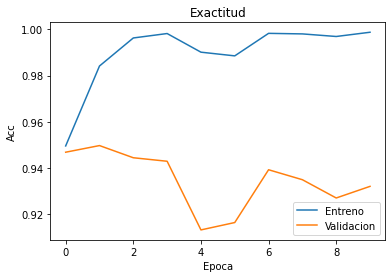

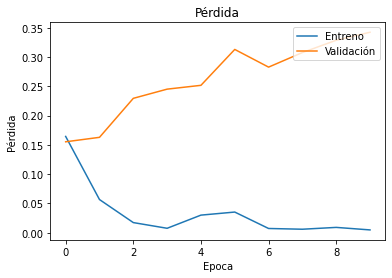

[[11951   549]
 [  304 12196]]

Exactitud:  0.9658799767494202
[[10172  2328]
 [ 1690 10810]]
Exactitud:  0.8392800092697144


In [36]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=10

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_ULSTM_Opt = keras.Model(inputs, outputs)
    model_ULSTM_Opt.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_ULSTM_Opt.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_ULSTM_Opt.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_ULSTM_Opt.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_ULSTM_Opt.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('model_ULSTM_Opt_part='+str(r)+'.h5')
        model_ULSTM_Opt.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Y_predt = model_ULSTM_Opt.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("\nExactitud: ", model_ULSTM_Opt.evaluate(x=x_train, y=y_train, verbose=0)[1])

Y_predv = model_ULSTM_Opt.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_ULSTM_Opt.evaluate(x=x_val, y=y_val, verbose=0)[1])

**Podemos observar que al incrementar las epocas en un un modelo Unidireccional con celdas LSTM no mejora el desempeño, cayó de 85% a 84%**

## 1.2.3 Red Unidireccional GRU

In [42]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades GRU unidireccionales
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_GRU_uni_Opt = keras.Model(inputs, outputs)
model_GRU_uni_Opt.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,622,273
Trainable params: 2,622,273
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=20

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_GRU_uni_Opt = keras.Model(inputs, outputs)
    model_GRU_uni_Opt.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_GRU_uni_Opt.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_GRU_uni_Opt.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_GRU_uni_Opt.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_GRU_uni_Opt.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('U_GRU_Opti_part='+str(r)+'.h5')
        model_GRU_uni_Opt.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Epoch 1/20
391/391 [==============================] - 80s 204ms/step - loss: 0.4705 - accuracy: 0.7599 - val_loss: 0.3485 - val_accuracy: 0.8542
Epoch 2/20
391/391 [==============================] - 82s 209ms/step - loss: 0.2201 - accuracy: 0.9173 - val_loss: 0.3416 - val_accuracy: 0.8626
Epoch 3/20
391/391 [==============================] - 80s 206ms/step - loss: 0.1304 - accuracy: 0.9548 - val_loss: 0.4999 - val_accuracy: 0.8284
Epoch 4/20
391/391 [==============================] - 81s 207ms/step - loss: 0.1029 - accuracy: 0.9630 - val_loss: 0.5023 - val_accuracy: 0.7994
Epoch 5/20
391/391 [==============================] - 79s 203ms/step - loss: 0.0682 - accuracy: 0.9752 - val_loss: 0.5669 - val_accuracy: 0.8343
Epoch 6/20
391/391 [==============================] - 79s 203ms/step - loss: 0.0259 - accuracy: 0.9915 - val_loss: 0.9308 - val_accuracy: 0.8194
Epoch 7/20
391/391 [==============================] - 78s 199ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.7412 - val_ac

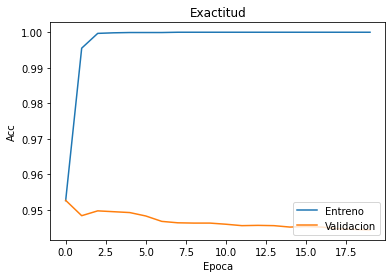

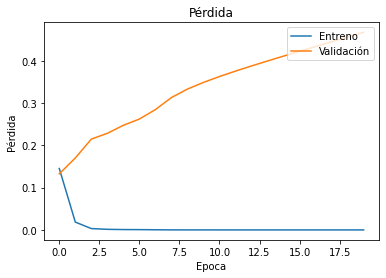

In [44]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [45]:
Y_predt = model_GRU_uni_Opt.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("\nExactitud: ", model_GRU_uni_Opt.evaluate(x=x_train, y=y_train, verbose=0)[1])

Y_predv = model_GRU_uni_Opt.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_GRU_uni_Opt.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[12101   399]
 [  296 12204]]

Exactitud:  0.9721999764442444
[[10672  1828]
 [ 1730 10770]]
Exactitud:  0.8576800227165222


Al aumentar a 20 Epocas, no se logra mejorar la exactidud (86%) y el aumento en el tiempo computacional es significativo comparado con la mejora que se puede lograr. Este parece no ser el camino si se quiere mejorar significativamente los resultados. 

## 1.2.4 Red Bidireccional GRU

In [46]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model_GRU_BID = keras.Model(inputs, outputs)
model_GRU_BID.summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         74496     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,709,121
Trainable params: 2,709,121
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
391/391 [==============================] - 118s 303ms/step - loss: 0.4978 - accuracy: 0.7485 - val_loss: 0.3657 - val_accuracy: 0.8450
Epoch 2/3
391/391 [==============================] - 110s 283ms/step - loss: 0.2326 - accuracy: 0.9096 - val_loss: 0.4131 - val_accuracy: 0.8570
Epoch 3/3
391/391 [==============================] - 113s 289ms/step - loss: 0.1187 - accuracy: 0.9573 - val_loss: 0.5335 - val_accuracy: 0.8466
Desempeño (exactitud): accu_v1=0.846560001373291 , accu_v2=0.8319600224494934
Epoch 1/3
391/391 [==============================] - 111s 283ms/step - loss: 0.2161 - accuracy: 0.9185 - val_loss: 0.2003 - val_accuracy: 0.9249
Epoch 2/3
391/391 [==============================] - 105s 269ms/step - loss: 0.0702 - accuracy: 0.9785 - val_loss: 0.2687 - val_accuracy: 0.9150
Epoch 3/3
391/391 [==============================] - 115s 294ms/step - loss: 0.0297 - accuracy: 0.9914 - val_loss: 0.6094 - val_accuracy: 0.8523
Desempeño (exactitud): accu_v1=0.8523200154304504 , 

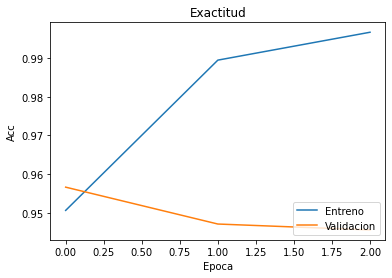

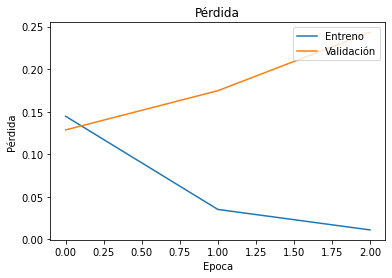

[[12277   223]
 [  472 12028]]

Exactitud:  0.9721999764442444
[[10672  1828]
 [ 1730 10770]]
Exactitud:  0.8551599979400635


In [47]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_GRU_BID = keras.Model(inputs, outputs)
    model_GRU_BID.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_GRU_BID.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_GRU_BID.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_GRU_BID.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_GRU_BID.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('B_GRU_Opt_part='+str(r)+'.h5')
        model_GRU_BID.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Y_predt = model_GRU_BID.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("\nExactitud: ", model_GRU_BID.evaluate(x=x_train, y=y_train, verbose=0)[1])

Y_predv = model_GRU_uni_Opt.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_GRU_BID.evaluate(x=x_val, y=y_val, verbose=0)[1])

**Podemos observar que un modelo mas sencillo (una red unidireccional GRU) presentó mejores resultados que sus competidores mas complejos (LSTM bidireccional) aun con un menor numero de epocas para la obtencion de sus parametros.**

**Podemos evidenciar que en todas las comparaciones, los modelos unidireccionales tuvieron un mejor rendimiento que los bidireccionales.**

**El camino a seguir sería optimizar sus parametros de aprendizaje, arquitectura, tasas de drop out entre sus capas y funciones de activacion.**